# EDA of the relationship between stock price direction and the content of 10K / 10Q reports

# 0. Disclaimer
The author does not accept responsibility for actions taken on the basis of information obtained as a result of using this materials. The author does not represent that the information or opinions provided are correct or complete. The information presented shouldn't be used as the sole guide for making investment decisions. Doesn't individual investment advice.

# 1. Problem and key areas of the analysis

**Forms 10K and 10Q** are among the most important reporting forms for publicly traded companies in USA:

* Form 10-K is an annual comprehensive report filed by companies with the SEC, detailing their financial performance and business operations. It includes audited financial statements, management's discussion and analysis, risk factors, and other important disclosures.

* Form 10-Q contains financial statements, management discussion and analysis, disclosures, and internal controls for the previous quarter. Companies must file their 10-Qs 40 or 45 days after the end of their quarters, depending on the size of their public float.

**Dataset.** Analysis was performed using the next data:
* Loughran-McDonald SEC/EDGAR dataset
* Cleaned files from the stage one parsing process
* Time period: 

This **feature analysis** involves next areas: 
* Full content of 10K/10Q form 
* Section of Management discussion and analysis (MDA)
* Risk Factors section (if applicable, principally for 10K form)

The **target variable** is defined as follows:
* Three gradations of stock price direction: up (1), down (-1), no change (0)
* Boundaries for the "no change" category: no more than 0,5% up / down, 
* To determine the value of the target variable, price changes were used on the following horizons: 3 days, 10 days, 30 days

If the quotation day fell on a day off, the first earlier day (for the previous day) or the first following working day (for the next day) was taken.

# 2. Feature and targets generation

In [1]:
import pandas as pd
from joblib import Parallel, delayed

N_CORES = -1 # -1: all avaliable cores

df = pd.read_csv('/Users/pavel/Documents/NLP_stock_model/nlp-stock-model/data/final_data.csv', index_col=0)

df['full_content'] = Parallel(n_jobs=-1)(delayed(eval)(content) for content in df['full_content'])

df_10q = df[df['report_type'] == '10-Q']
df_10k = df[df['report_type'] == '10-K']

# 3. Analyzing text statistics

### 3.1. Sentence length analysis

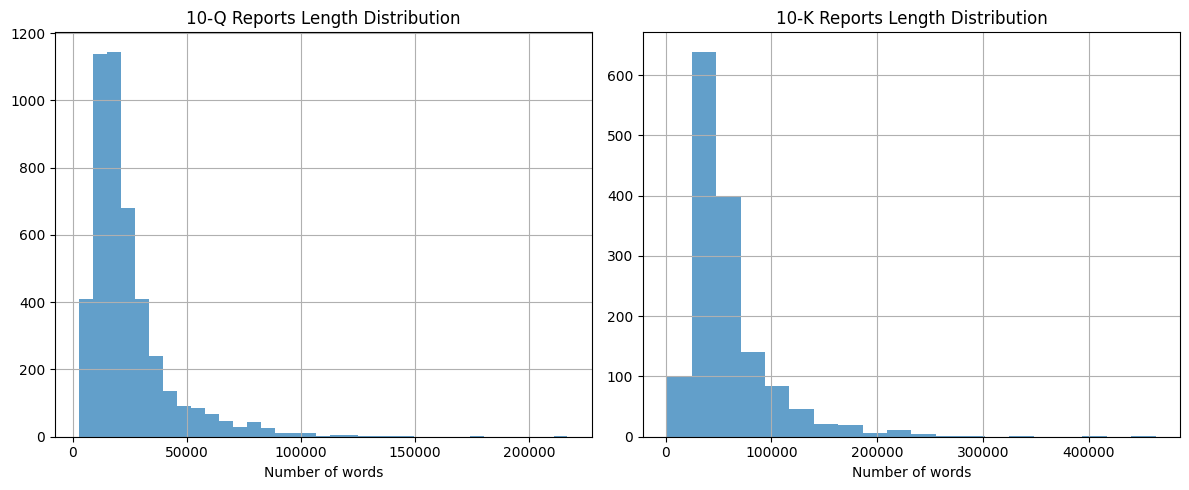

In [2]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(df_10q['full_content_length'], bins=35, alpha=0.7)
ax1.set_title('10-Q Reports Length Distribution')
ax1.set_xlabel('Number of words')
ax1.grid()

ax2.hist(df_10k['full_content_length'], bins=20, alpha=0.7)
ax2.set_title('10-K Reports Length Distribution')
ax2.set_xlabel('Number of words')
ax2.grid()

plt.tight_layout()
plt.show()

In [3]:
df_10q.full_content_length.describe()

count      4597.000000
mean      23795.325430
std       17678.004018
min        2745.000000
25%       12903.000000
50%       18703.000000
75%       28129.000000
max      216823.000000
Name: full_content_length, dtype: float64

In [4]:
df_10k.full_content_length.describe()

count      1476.000000
mean      59244.790650
std       41332.316187
min        1564.000000
25%       35745.500000
50%       47659.000000
75%       67446.500000
max      463454.000000
Name: full_content_length, dtype: float64

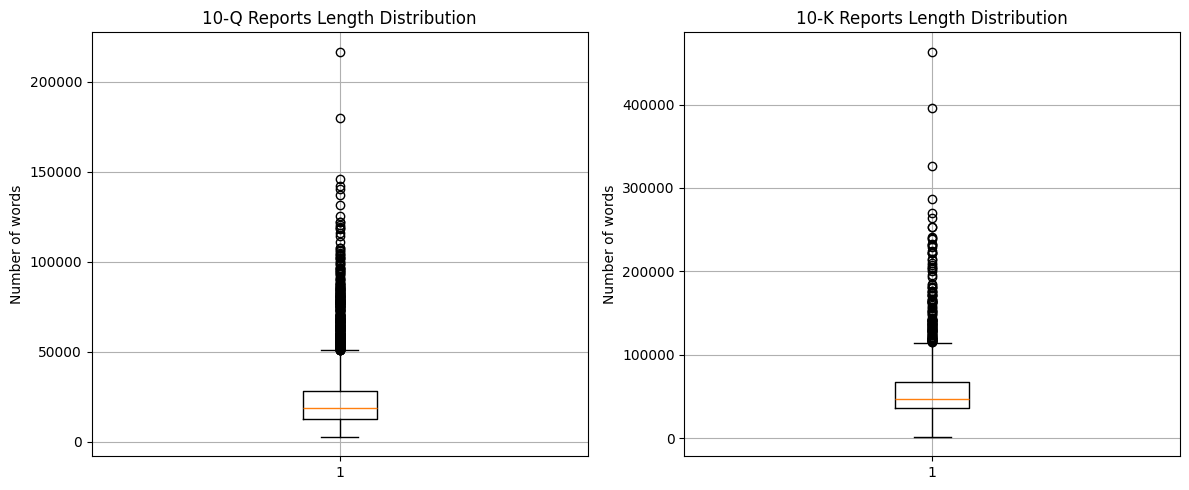

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.boxplot(df_10q['full_content_length'])
ax1.set_title('10-Q Reports Length Distribution')
ax1.set_ylabel('Number of words')
ax1.grid()

ax2.boxplot(df_10k['full_content_length'])
ax2.set_title('10-K Reports Length Distribution')
ax2.set_ylabel('Number of words')
ax2.grid()

plt.tight_layout()
plt.show()

The sample contains outliers - long reports. For the 10-Q form, these are reports longer than 50 000 words, for 10-K reports - more than 110 000 words. Let's explore the characteristics of these reports.

In [6]:
percent_long_reports_10q = df_10q[df_10q['full_content_length'] > 50000].shape[0] / df_10q.shape[0] * 100
print(f'Percent of long reports in 10-Q: {percent_long_reports_10q:.2f}%')

percent_long_reports_10k = df_10k[df_10k['full_content_length'] > 110000].shape[0] / df_10q.shape[0] * 100
print(f'Percent of long reports in 10-K: {percent_long_reports_10k:.2f}%')

Percent of long reports in 10-Q: 8.05%
Percent of long reports in 10-K: 2.94%


In [7]:
long_reports_10q = df_10q[df_10q['full_content_length'] > 50000]
long_reports_10k = df_10k[df_10k['full_content_length'] > 110000]

long_reports_10q['publication_date'] = pd.to_datetime(long_reports_10q['publication_date'])
long_reports_10q['publication_date'].describe()

In [9]:
long_reports_10k['publication_date'] = pd.to_datetime(long_reports_10k['publication_date'])
long_reports_10k['publication_date'].describe()

/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_52806/3754088620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reports_10k['publication_date'] = pd.to_datetime(long_reports_10k['publication_date'])


count                    135
mean     2015-02-14 13:30:40
min      2004-03-01 00:00:00
25%      2010-08-16 00:00:00
50%      2015-02-27 00:00:00
75%      2020-02-12 12:00:00
max      2023-02-28 00:00:00
Name: publication_date, dtype: object

In [10]:
long_reports_10k.report_date.value_counts().head(10)

report_date
2022-12-31    11
2021-12-31     9
2016-12-31     8
2012-12-31     8
2014-12-31     8
2008-12-31     7
2013-12-31     7
2018-12-31     7
2019-12-31     6
2020-12-31     6
Name: count, dtype: int64

In [11]:
long_reports_10q['ticker'].value_counts().head(10)

ticker
AEP     58
SO      52
JPM     46
DUK     20
CSCO    11
SRE     10
GILD    10
MDLZ    10
AMGN    10
VRTX     9
Name: count, dtype: int64

In [12]:
long_reports_10k['ticker'].value_counts().head(10)

ticker
AEP    20
SO     19
JPM    16
DUK     8
FCX     7
SRE     6
T       5
BMY     5
PEP     4
KMI     4
Name: count, dtype: int64

### 3.2. Testing the statistical significance of the difference in average text length

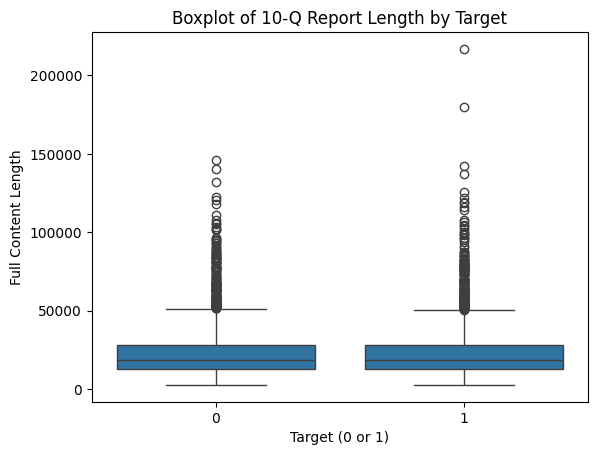

In [13]:
import seaborn as sns

sns.boxplot(x='target_3', y='full_content_length', data=df_10q)
plt.title('Boxplot of 10-Q Report Length by Target')
plt.xlabel('Target (0 or 1)')
plt.ylabel('Full Content Length')
plt.show()

In [14]:
from scipy import stats

group_0 = df_10q[df_10q['target_3'] == 0]['full_content_length']
group_1 = df_10q[df_10q['target_3'] == 1]['full_content_length']

shapiro_test_group_0 = stats.shapiro(group_0)
shapiro_test_group_1 = stats.shapiro(group_1)

print(f'Shapiro-Wilk test for group 0: Statistic={shapiro_test_group_0.statistic:.2f}, p-value={shapiro_test_group_0.pvalue:.2f}')
print(f'Shapiro-Wilk test for group 1: Statistic={shapiro_test_group_1.statistic:.2f}, p-value={shapiro_test_group_1.pvalue:.2f}')

Shapiro-Wilk test for group 0: Statistic=0.78, p-value=0.00
Shapiro-Wilk test for group 1: Statistic=0.75, p-value=0.00


According to the Shapiro-Wilk test, the distribution of text length in samples where there was growth in shares and where there was a decline is not normal. The t-test is not applicable

In [15]:
from scipy import stats

u_statistic, p_value_mw = stats.mannwhitneyu(group_0, group_1)

print(f'Mann-Whitney U statistic: {u_statistic:.2f}, p-value: {p_value_mw:.2f}')

Mann-Whitney U statistic: 2667101.00, p-value: 0.47


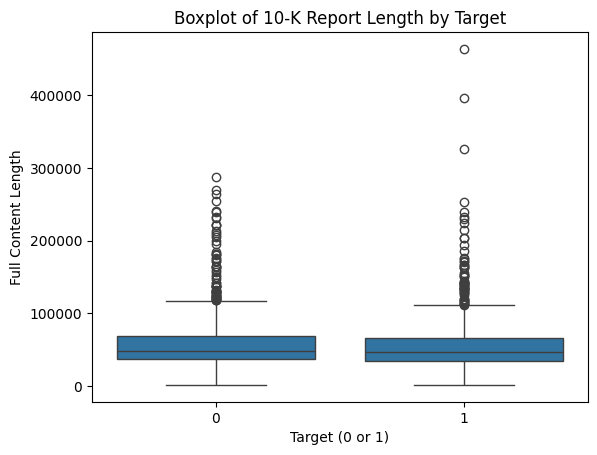

In [16]:
sns.boxplot(x='target_3', y='full_content_length', data=df_10k)
plt.title('Boxplot of 10-K Report Length by Target')
plt.xlabel('Target (0 or 1)')
plt.ylabel('Full Content Length')
plt.show()

In [17]:
group_0 = df_10k[df_10k['target_3'] == 0]['full_content_length']
group_1 = df_10k[df_10k['target_3'] == 1]['full_content_length']

shapiro_test_group_0 = stats.shapiro(group_0)
shapiro_test_group_1 = stats.shapiro(group_1)

print(f'Shapiro-Wilk test for group 0: Statistic={shapiro_test_group_0.statistic:.2f}, p-value={shapiro_test_group_0.pvalue:.2f}')
print(f'Shapiro-Wilk test for group 1: Statistic={shapiro_test_group_1.statistic:.2f}, p-value={shapiro_test_group_1.pvalue:.2f}')

Shapiro-Wilk test for group 0: Statistic=0.77, p-value=0.00
Shapiro-Wilk test for group 1: Statistic=0.71, p-value=0.00


In [90]:
u_statistic, p_value_mw = stats.mannwhitneyu(group_0, group_1)

print(f'Mann-Whitney U statistic: {u_statistic:.2f}, p-value: {p_value_mw:.2f}')

Mann-Whitney U statistic: 287521.50, p-value: 0.06


10-K reports for gaining stocks are shorter than those for declining stocks. On average, gaining stocks contain 58,000 words, while declining stocks contain 61,000 words (the difference is significant at a p-value of 0.06).

In general, it can be said that long reports are not associated with any dates (for example, dates when there was a financial crisis, or COVID, etc.).

The companies that publish the longest reports (and the leaders are also in 10-Q and 10-K reports), these are:
* AEP - American Electric Power Company, Inc. (an energy company)
* SO - Southern Company, Inc. (an energy company, provides services in the southeastern United States)
* JPM - JPMorgan Chase & Co. (one of the largest financial companies in the United States and the world)
* DUK - Duke Energy Corporation (an energy company in the Carolinas, Florida and the Midwest)

Distribution of further price dynamics depending on the length of the text will be further studied after constructing histograms for the whole sample

The analysis was carried out for price dynamics within 3 days after the release of reports, without taking into account the 0.5% interval discussed in section 1

### 3.3. Target variable analysis

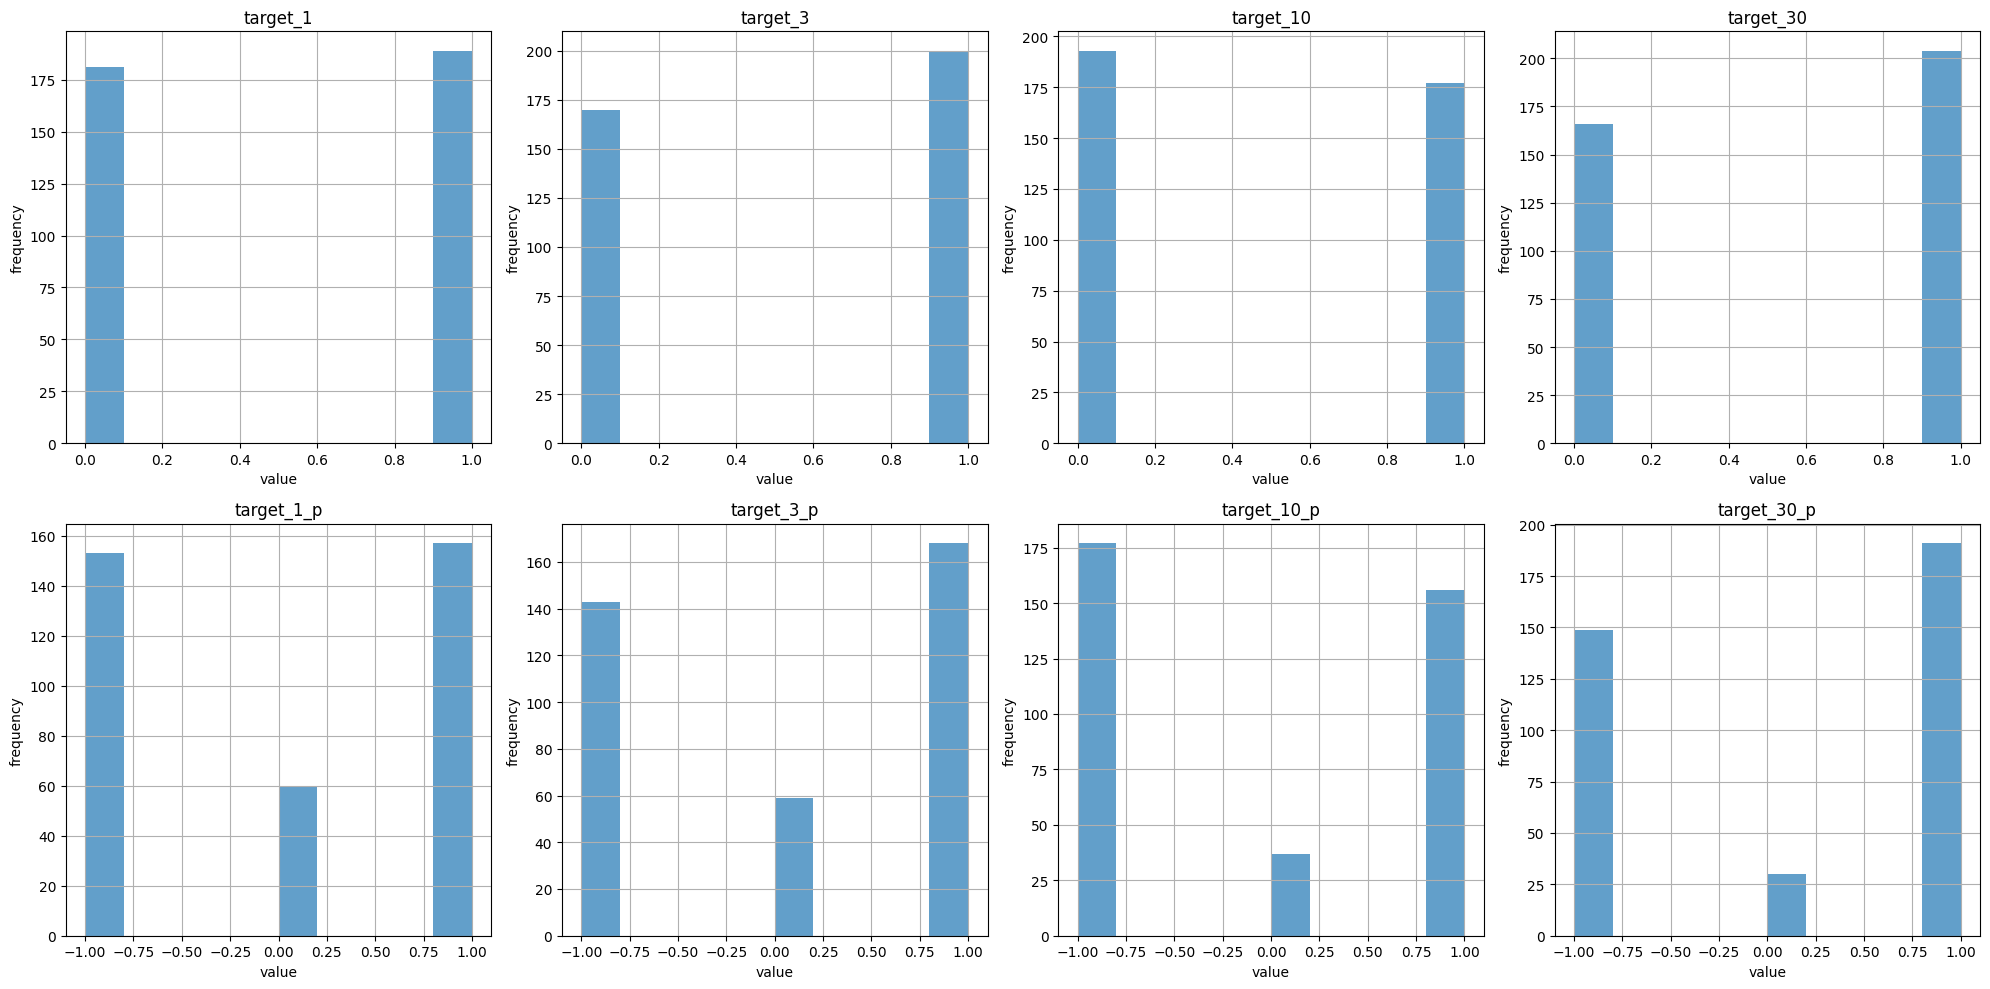

In [91]:
variables = ['target_1', 'target_3', 'target_10', 'target_30', 
             'target_1_p', 'target_3_p', 'target_10_p', 'target_30_p']

num_vars = len(variables)
cols = 4
rows = (num_vars + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, var in enumerate(variables):
    axes[i].hist(long_reports_10q[var], bins=10, alpha=0.7)
    axes[i].set_title(var)
    axes[i].set_xlabel('value')
    axes[i].set_ylabel('frequency')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

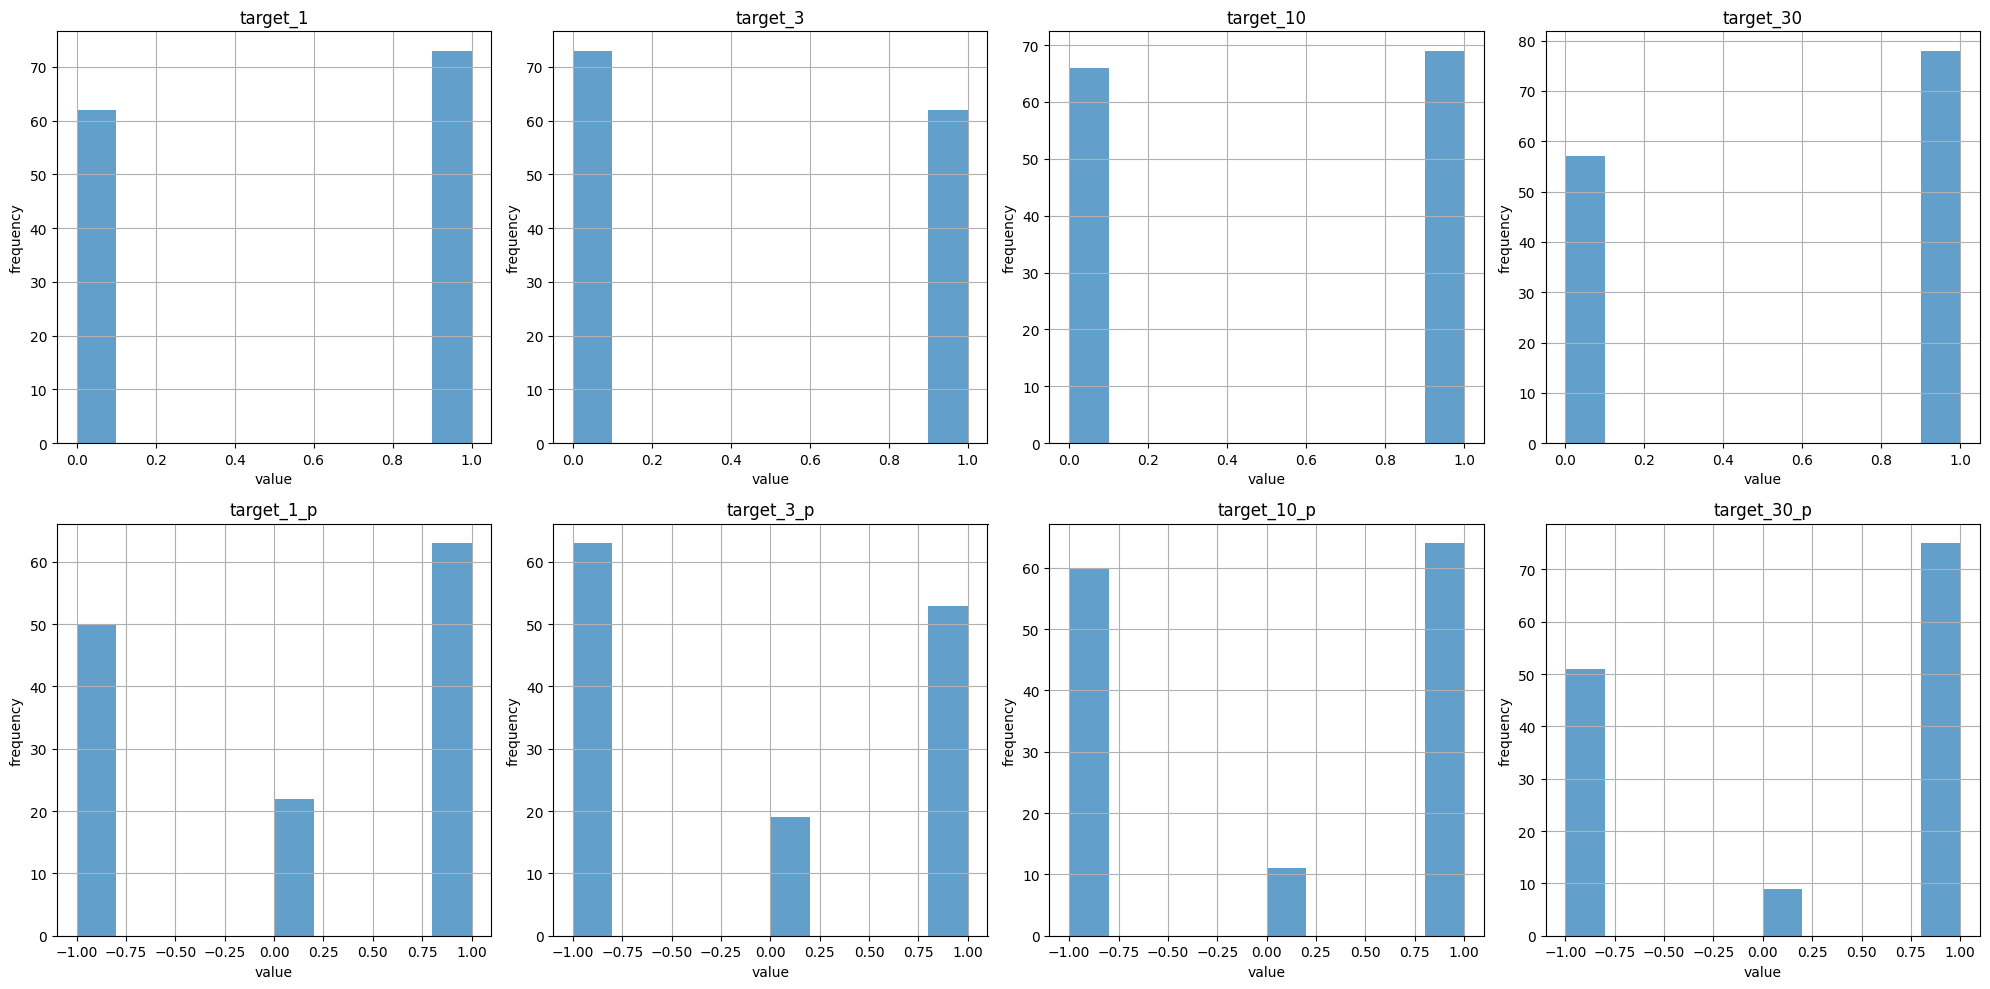

In [92]:
num_vars = len(variables)
cols = 4
rows = (num_vars + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, var in enumerate(variables):
    axes[i].hist(long_reports_10k[var], bins=10, alpha=0.7)
    axes[i].set_title(var)
    axes[i].set_xlabel('value')
    axes[i].set_ylabel('frequency')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Key findings:
* The visual difference between the distribution of variables for long and short reports is insignificant
* For target variables with a threshold of 0.5%, the share of the class where the price would not change significantly is lower (value 0 of the target variable). Moreover, the longer the period for calculating the target variable, the smaller the share of this class
* Classes are balanced enough for subsequent training of the classification model.

# 4. Word frequency analysys

### 4.1. Most frequent words

/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_28002/3001515177.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq_3_1, y=words_3_1, ax=axes[0], palette='viridis')
/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_28002/3001515177.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq_3_0, y=words_3_0, ax=axes[1], palette='viridis')


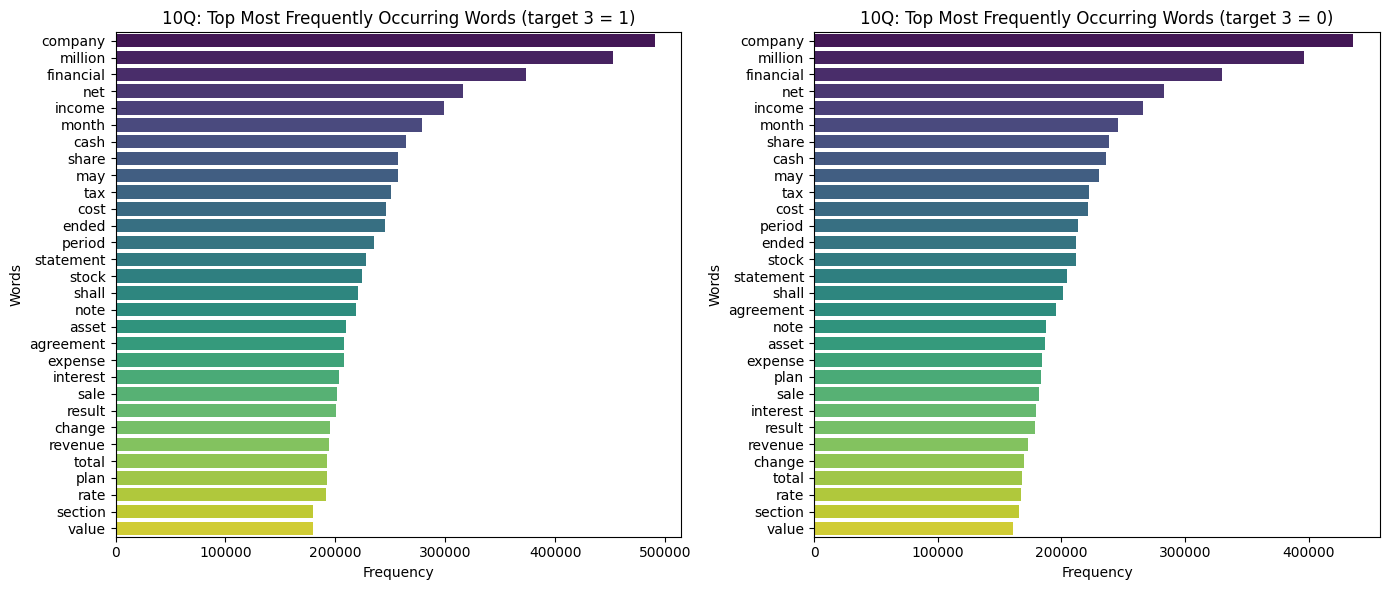

In [95]:
from collections import Counter
import seaborn as sns
from itertools import chain

corpus_10q_3_1 = list(chain.from_iterable(df_10q[df_10q['target_3'] == 1]['full_content']))
corpus_10q_3_0 = list(chain.from_iterable(df_10q[df_10q['target_3'] == 0]['full_content']))

mostCommon_10q_3_1 = Counter(word for word in corpus_10q_3_1 if word.isalpha()).most_common(30)
mostCommon_10q_3_0 = Counter(word for word in corpus_10q_3_0 if word.isalpha()).most_common(30)

words_3_1, freq_3_1 = zip(*mostCommon_10q_3_1)
words_3_0, freq_3_0 = zip(*mostCommon_10q_3_0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=freq_3_1, y=words_3_1, ax=axes[0], palette='viridis')
axes[0].set_title('10Q: Top Most Frequently Occurring Words (target 3 = 1)')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')

sns.barplot(x=freq_3_0, y=words_3_0, ax=axes[1], palette='viridis')
axes[1].set_title('10Q: Top Most Frequently Occurring Words (target 3 = 0)')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')

plt.tight_layout()
plt.show()

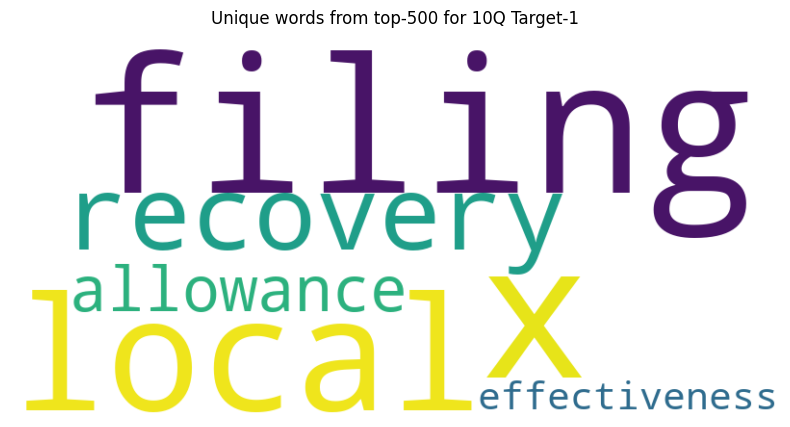

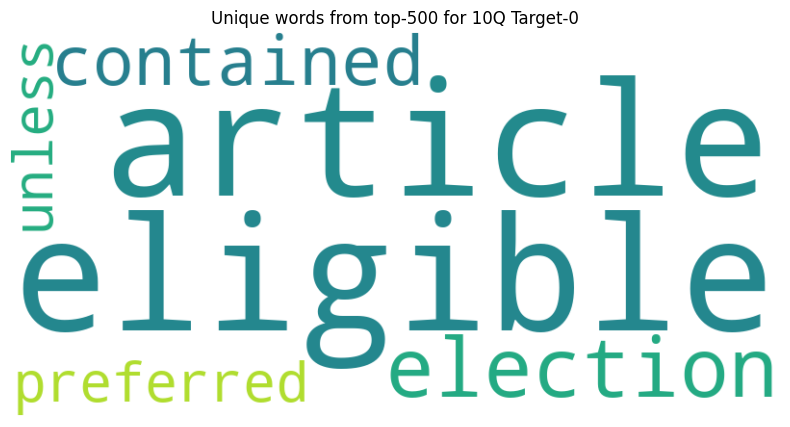

In [96]:
from wordcloud import WordCloud

mostCommon_10q_3_1 = Counter(word for word in corpus_10q_3_1 if word.isalpha()).most_common(500)
mostCommon_10q_3_0 = Counter(word for word in corpus_10q_3_0 if word.isalpha()).most_common(500)

common_dict_3_1 = dict(mostCommon_10q_3_1)
common_dict_3_0 = dict(mostCommon_10q_3_0)

unique_to_corpus_3_1 = set(common_dict_3_1.keys()) - set(common_dict_3_0.keys())
unique_to_corpus_3_0 = set(common_dict_3_0.keys()) - set(common_dict_3_1.keys())

def create_word_cloud(unique_words, title):
    text = ' '.join(unique_words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

create_word_cloud(unique_to_corpus_3_1, "Unique words from top-500 for 10Q Target-1")
create_word_cloud(unique_to_corpus_3_0, "Unique words from top-500 for 10Q Target-0")

/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_28002/2229523266.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq_3_1, y=words_3_1, ax=axes[0], palette='viridis')
/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_28002/2229523266.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq_3_0, y=words_3_0, ax=axes[1], palette='viridis')


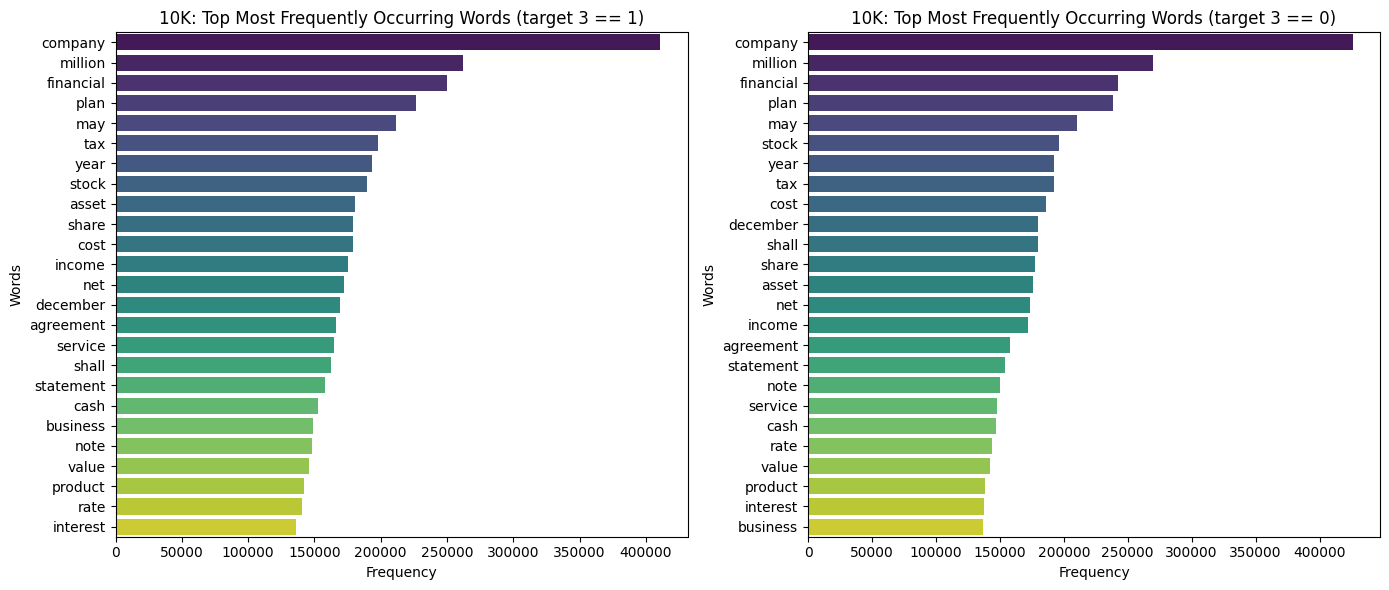

In [97]:
df_10k_target_3_1 = df_10k[df_10k['target_3'] == 1]
df_10k_target_3_0 = df_10k[df_10k['target_3'] == 0]

corpus_10k_3_1 = list(chain.from_iterable(df_10k[df_10k['target_3'] == 1]['full_content']))
corpus_10k_3_0 = list(chain.from_iterable(df_10k[df_10k['target_3'] == 0]['full_content']))

mostCommon_10k_3_1 = Counter(word for word in corpus_10k_3_1 if word.isalpha()).most_common(25)
mostCommon_10k_3_0 = Counter(word for word in corpus_10k_3_0 if word.isalpha()).most_common(25)

words_3_1, freq_3_1 = zip(*mostCommon_10k_3_1)
words_3_0, freq_3_0 = zip(*mostCommon_10k_3_0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=freq_3_1, y=words_3_1, ax=axes[0], palette='viridis')
axes[0].set_title('10K: Top Most Frequently Occurring Words (target 3 == 1)')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')

sns.barplot(x=freq_3_0, y=words_3_0, ax=axes[1], palette='viridis')
axes[1].set_title('10K: Top Most Frequently Occurring Words (target 3 == 0)')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')

plt.tight_layout()
plt.show()

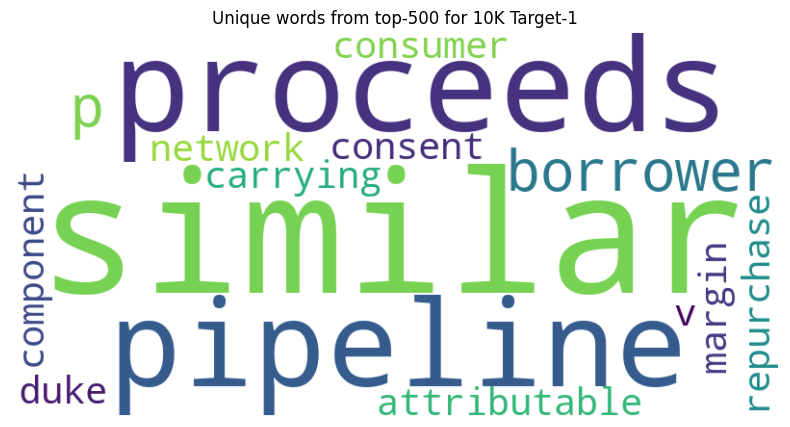

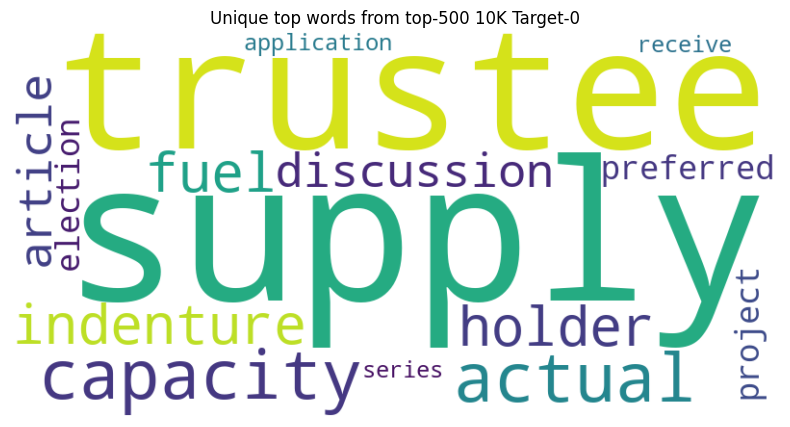

In [98]:
mostCommon_10k_3_1 = Counter(word for word in corpus_10k_3_1 if word.isalpha()).most_common(400)
mostCommon_10k_3_0 = Counter(word for word in corpus_10k_3_0 if word.isalpha()).most_common(400)

common_dict_3_1 = dict(mostCommon_10k_3_1)
common_dict_3_0 = dict(mostCommon_10k_3_0)

unique_to_corpus_3_1 = set(common_dict_3_1.keys()) - set(common_dict_3_0.keys())
unique_to_corpus_3_0 = set(common_dict_3_0.keys()) - set(common_dict_3_1.keys())

def create_word_cloud(unique_words, title):
    text = ' '.join(unique_words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

create_word_cloud(unique_to_corpus_3_1, "Unique words from top-500 for 10K Target-1")
create_word_cloud(unique_to_corpus_3_0, "Unique top words from top-500 10K Target-0")

Words with positive connotations are more common among companies whose stocks rose after the 10K report, while words with negative connotations are more common among those that fell:
* words net and income, business, cash are higher in the top for stocks that rose after the report
* words interest and rate, cost are higher among stocks that fell

Above are the words from the top 500 that are in one group but not in another for 10-Q report:
* stocks that rose after the release of the report contained unique words with a positive connotation: recovery, effectiveness, allowance
* the word election in falling companies may indicate political events that led to negative changes in the regulation of the industry
* the word unless in falling companies may indicate some negative set of circumstances

The analysis was carried out for price dynamics within 3 days after the release of reports, without taking into account the 0.5% interval discussed in section 1

### 4.2. Most frequently n-grams

Due to large text corpus, it is not possible to construct bigrams using the CountVectorizer. HashingVectorizer was used.

HashingVectorizer also has the following limitations:

* It is not possible to invert the model (there is no inverse_transform method) and it is not possible to access the original string representation of features due to the one-way nature of the hash function that performs the encoding.

* It does not provide IDF weighting, as this would introduce statefulness into the model. If needed, a TfidfTransformer can be added to it in the pipeline.

/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_28002/3052603151.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ngram_freq_3_1_10q['frequency'][:20], y=ngram_freq_3_1_10q['ngram'][:20], palette='viridis')
/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_28002/3052603151.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ngram_freq_3_0_10q['frequency'][:20], y=ngram_freq_3_0_10q['ngram'][:20], palette='viridis')


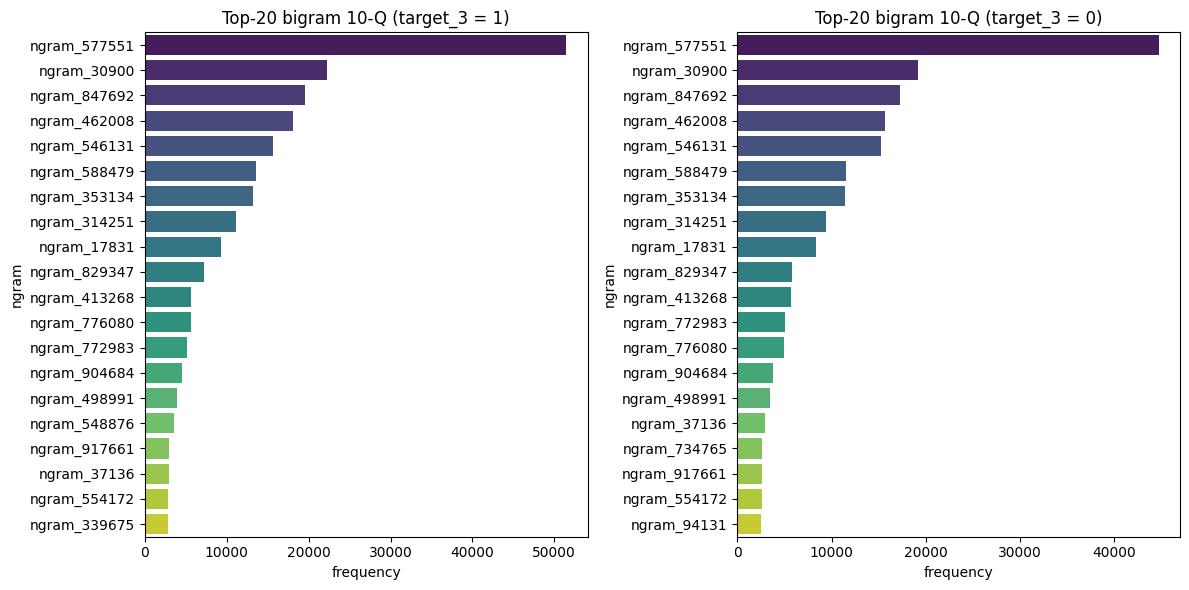

In [99]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(ngram_range=(2, 2), n_features=2**20)

bigrams_3_1_10q = vectorizer.transform(corpus_10q_3_1)
bigrams_3_0_10q = vectorizer.transform(corpus_10q_3_0)

count_values_3_1_10q = bigrams_3_1_10q.sum(axis=0).A1
count_values_3_0_10q = bigrams_3_0_10q.sum(axis=0).A1

feature_names = [f"ngram_{i}" for i in range(2**20)]

ngram_freq_3_1_10q = pd.DataFrame(sorted(zip(count_values_3_1_10q, feature_names), reverse=True), columns=["frequency", "ngram"])
ngram_freq_3_0_10q = pd.DataFrame(sorted(zip(count_values_3_0_10q, feature_names), reverse=True), columns=["frequency", "ngram"])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=ngram_freq_3_1_10q['frequency'][:20], y=ngram_freq_3_1_10q['ngram'][:20], palette='viridis')
plt.title('Top-20 bigram 10-Q (target_3 = 1)')

plt.subplot(1, 2, 2)
sns.barplot(x=ngram_freq_3_0_10q['frequency'][:20], y=ngram_freq_3_0_10q['ngram'][:20], palette='viridis')
plt.title('Top-20 bigram 10-Q (target_3 = 0)')

plt.tight_layout()
plt.show()

/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_28002/3121409583.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ngram_freq_3_1_10k['frequency'][:20], y=ngram_freq_3_1_10k['ngram'][:20], palette='viridis')
/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_28002/3121409583.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ngram_freq_3_0_10k['frequency'][:20], y=ngram_freq_3_0_10k['ngram'][:20], palette='viridis')


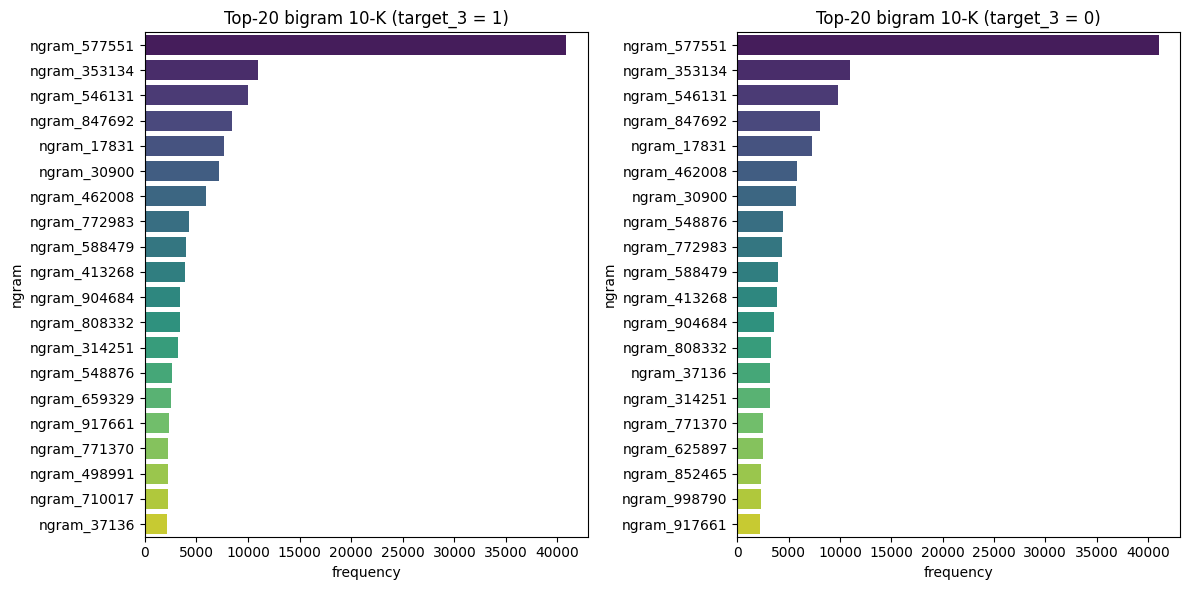

In [100]:
bigrams_3_1_10k = vectorizer.transform(corpus_10k_3_1)
bigrams_3_0_10k = vectorizer.transform(corpus_10k_3_0)

count_values_3_1_10k = bigrams_3_1_10k.sum(axis=0).A1
count_values_3_0_10k = bigrams_3_0_10k.sum(axis=0).A1

feature_names = [f"ngram_{i}" for i in range(2**20)]

ngram_freq_3_1_10k = pd.DataFrame(sorted(zip(count_values_3_1_10k, feature_names), reverse=True), columns=["frequency", "ngram"])
ngram_freq_3_0_10k = pd.DataFrame(sorted(zip(count_values_3_0_10k, feature_names), reverse=True), columns=["frequency", "ngram"])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=ngram_freq_3_1_10k['frequency'][:20], y=ngram_freq_3_1_10k['ngram'][:20], palette='viridis')
plt.title('Top-20 bigram 10-K (target_3 = 1)')

plt.subplot(1, 2, 2)
sns.barplot(x=ngram_freq_3_0_10k['frequency'][:20], y=ngram_freq_3_0_10k['ngram'][:20], palette='viridis')
plt.title('Top-20 bigram 10-K (target_3 = 0)')

plt.tight_layout()
plt.show()

The results of the analysis show differences between the subsamples where there was an increase in shares and where there was a decrease. The differences are visible both at the level of individual words and at the level of bigrams.